# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
!pip install matplotlib==3.5.0

In [2]:
!pip show matplotlib

Name: matplotlib
Version: 3.5.0
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /opt/conda/lib/python3.9/site-packages
Requires: cycler, kiwisolver, pyparsing, fonttools, setuptools-scm, packaging, python-dateutil, pillow, numpy
Required-by: seaborn, pyod, catboost


In [3]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Загрузка и подготовка данных

Загрузите и подготовьте данные. Поясните порядок действий.

In [5]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')

data_1 = pd.read_csv('/datasets/geo_data_1.csv')

data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


узнаю сколько нефти приходится на каждую скважину. для этого сначала узнаю уникальные значения, удалю столбцы id, создам функцию и построю по ней гистограмму для отображения объема скважин

In [9]:
def unique_columns(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
        
unique_columns(data_0) 
print()
unique_columns(data_1)
print()
unique_columns(data_2)

Уникальные значения столбца id
['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
Уникальные значения столбца f0
[0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]
Уникальные значения столбца f1
[-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]
Уникальные значения столбца f2
[ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]
Уникальные значения столбца product
[105.28006184  73.03775027  85.26564713 ...  64.37544259  74.04076435
 149.63324561]

Уникальные значения столбца id
['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
Уникальные значения столбца f0
[-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]
Уникальные значения столбца f1
[-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]
Уникальные значения столбца f2
[-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]
Уникальные значения столб

In [10]:
#удаляю id, тк не имеет значимости
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)

In [11]:
#функция для построения гистограммы
def oil_hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[10,7])
    plt.hist(seria, bins=bins)
    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])
    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")
    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

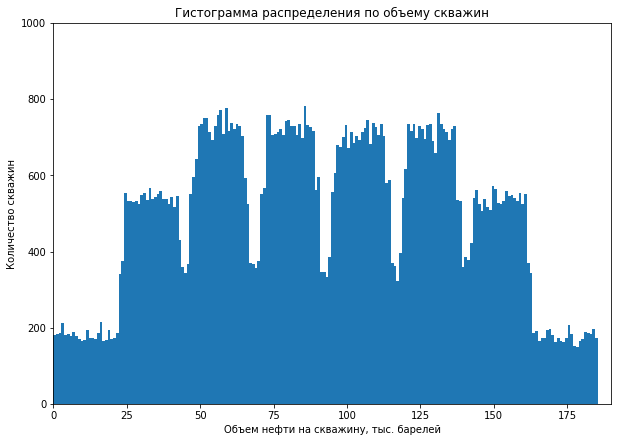

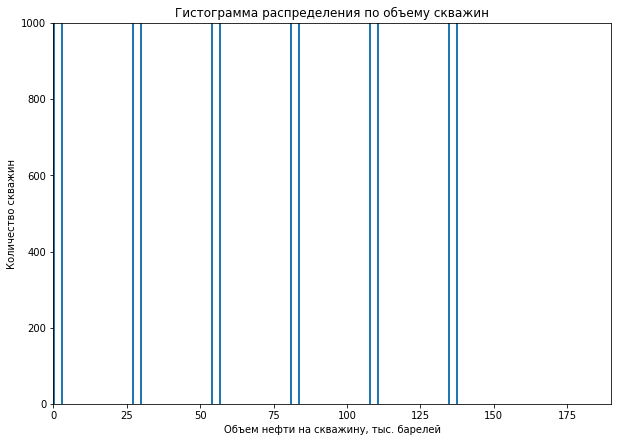

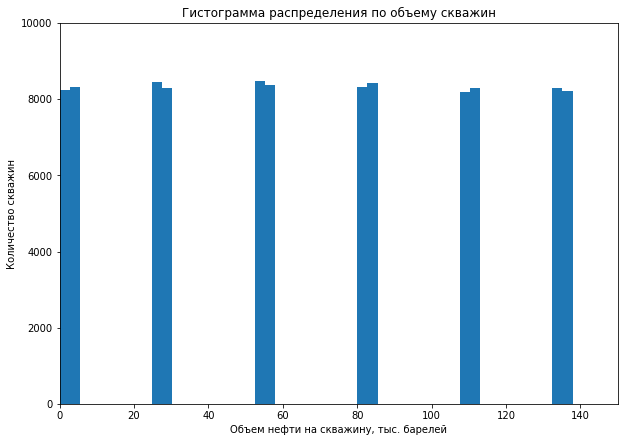

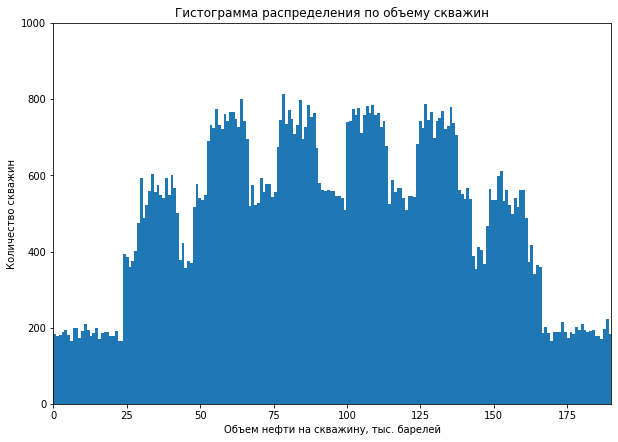

In [12]:
#строю гистрограмму
oil_hist(data_0['product'], 200, 190, 1000)
oil_hist(data_1['product'], 200, 190, 1000)
oil_hist(data_1['product'], 50, 150, 10000)
oil_hist(data_2['product'], 200, 190, 1000)

Признаки для модели хранятся в стоблцах: f0, f1, f2.


Целевой признак: product.

Вывод по данному шагу:
Данные подготовлены. Пропусков нет.

По гистограммам можно понять, что у первого и третьего региона распределение скважин близкое к нормальному. Во втором регионе данные имеют странное распределение: от 0 до 5 баррелей с шагом по 15-20 равномерно распределены 100000 значений. Данные не подчиняются закону больших чисел и скорей всего были введены искуственно.

## Обучение и проверка модели

Обучите и проверьте модель для каждого региона:

 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
 
 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
 
 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
 
 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
 
 2.5. Проанализируйте результаты.

In [13]:
model = LinearRegression()

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [16]:
data_0_predicted, data_0_rmse, data_0_predicted_mean, data_0_predicted_sum = oil_predict(data_0, 'product')
print(data_0_predicted.head())
print('RMSE -', data_0_rmse)
print('Средний запас запасанного сырья -', data_0_predicted_mean)

          product  predicted_product
71751   10.038645          95.894952
80493  114.551489          77.572583
2655   132.603635          77.892640
53233  169.072125          90.175134
91141  122.325180          70.510088
RMSE - 37.5794217150813
Средний запас запасанного сырья - 92.59256778438035


In [17]:
data_1_predicted, data_1_rmse, data_1_predicted_mean, data_1_predicted_sum = oil_predict(data_1, 'product')
print(data_1_predicted.head())
print('RMSE -', data_1_rmse)
print('Средний запас запасанного сырья -', data_1_predicted_mean)

         product  predicted_product
71751  80.859783          82.663314
80493  53.906522          54.431786
2655   30.132364          29.748760
53233  53.906522          53.552133
91141   0.000000           1.243856
RMSE - 0.893099286775617
Средний запас запасанного сырья - 68.728546895446


In [18]:
data_2_predicted, data_2_rmse, data_2_predicted_mean, data_2_predicted_sum = oil_predict(data_2, 'product')
print(data_2_predicted.head())
print('RMSE -', data_2_rmse)
print('Средний запас запасанного сырья -', data_2_predicted_mean)

          product  predicted_product
71751   61.212375          93.599633
80493   41.850118          75.105159
2655    57.776581          90.066809
53233  100.053761         105.162375
91141  109.897122         115.303310
RMSE - 40.02970873393434
Средний запас запасанного сырья - 94.96504596800489


Вывод

Самый высокий rmse  во втором регионе(RMSE - 0.893099286775617), чтоб может говорить о том, что модель лучше предсказала именно этот регион.

## Подготовка к расчёту прибыли

Подготовьтесь к расчёту прибыли:
 
 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.
 
 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
 
 3.3. Напишите выводы по этапу подготовки расчёта прибыли.

In [19]:
#для легкости восприятия и расчета переведу все в тысячи, получу прибыль в тысячах рублей за тысячу барелей
chosen_points = 500
best_points = 100
price_per_barrel = 450
budget = 1e+07 #миллиарды отображу таким образом

Расчитаю безубыточную разработку сырья на 100 месторождениях. И найду среднее количество продукта в месторождениях необходимое для этого.

In [20]:
#Расчитаю безубыточную разработку сырья на 100 месторождения
average_profit_per_point = budget / best_points
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / price_per_barrel
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. барелей')

average_barrels = budget / price_per_barrel
print('Средний объем нефти на регион -',average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку - 100000.0 тыс.руб.
Средний объем нефти на точку - 222.22222222222223 тыс. барелей
Средний объем нефти на регион - 22222.222222222223 тыс. барелей


In [21]:
#Расчитаю безубыточную разработку сырья на 200 месторождениях
best_points = 200

average_profit_per_point = budget / best_points
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / price_per_barrel
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. барелей')

average_barrels = budget / price_per_barrel
print('Средний объем нефти на регион -',average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку - 50000.0 тыс.руб.
Средний объем нефти на точку - 111.11111111111111 тыс. барелей
Средний объем нефти на регион - 22222.222222222223 тыс. барелей


In [22]:
#посмотрю запасы
print('Средний запас фактичекой нефти на скважину в регионе 1', data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2', data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3', data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2 68.82500000000002
Средний запас фактичекой нефти на скважину в регионе 3 95.00000000000004


у 1 и 3 больше шансов окупить затраты

In [26]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

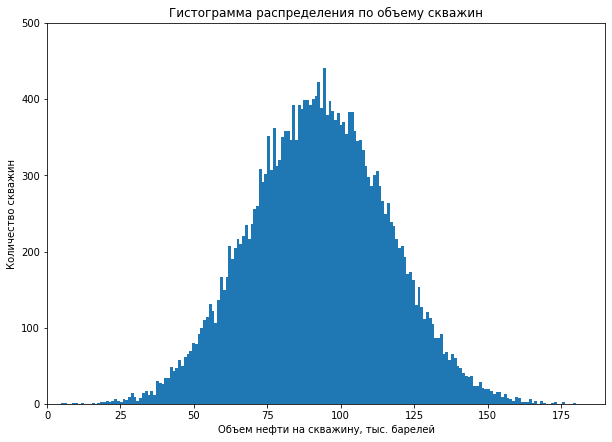

In [28]:
oil_hist(data_0_predicted['predicted_product'], 200, 190, 500)

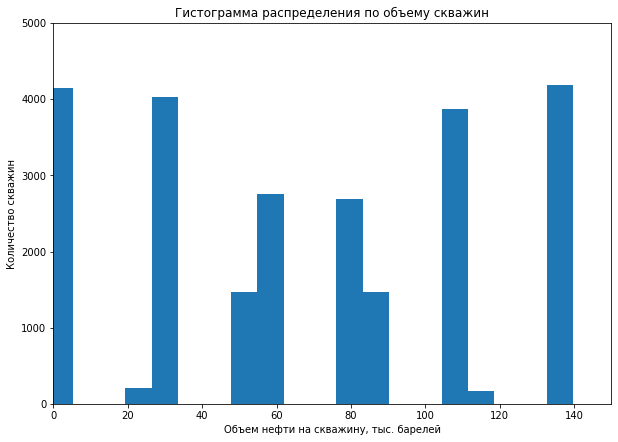

In [29]:
oil_hist(data_1_predicted['predicted_product'], 20, 150, 5000)

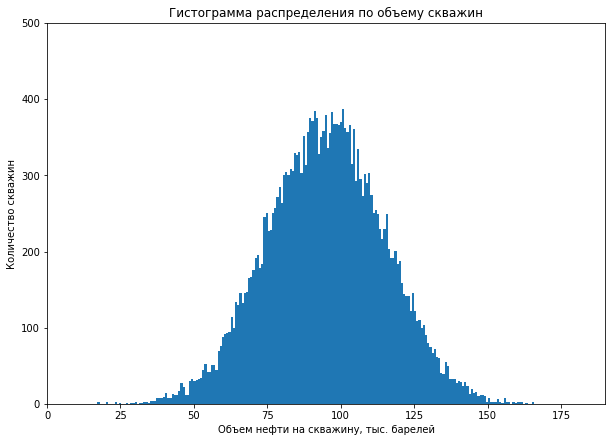

In [30]:
oil_hist(data_2_predicted['predicted_product'], 200, 190, 500)

Ожидаемо низкая средняя валовая прибыль у региона 2. Посмотрю выбросы по регионам 1 и 3, может именно там самые богатые месторождения. Для подтверждения теории, проверю медианы.

In [31]:
def boxplot (well):
    plt.boxplot(well)
    plt.show()

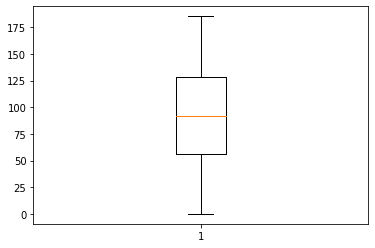

In [32]:
boxplot(data_0['product'])

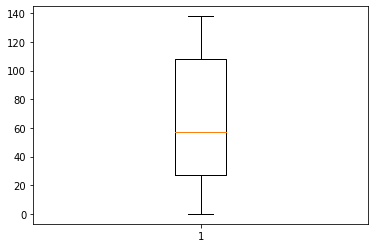

In [33]:
boxplot(data_1['product'])

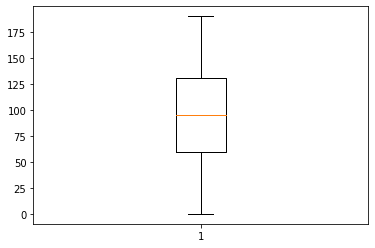

In [34]:
boxplot(data_2['product'])

Экстремально больших или малых значений нет. При этом в data_1 есть разброс в больших значениях, а значит вероятность попасть на скважину выше

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 
4.1. Выберите скважины с максимальными значениями предсказаний. 

4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.

4.3. Рассчитайте прибыль для полученного объёма сырья.

Посчитайте риски и прибыль для каждого региона:

5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [35]:
state = np.random.RandomState(5062020)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [38]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(data_0_predicted['product'], 
                                                     data_0_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по первому региону.
Средняя прибыль по региону = 384090.89 тыс.руб.
95% доверительный интервал от -134623.42 до 932651.95 тыс.руб.
Процент риска 9.20%


In [39]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(data_1_predicted['product'], 
                                                     data_1_predicted['predicted_product'])
print('Данные по второму региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по второму региону.
Средняя прибыль по региону = 458143.98 тыс.руб.
95% доверительный интервал от 51101.18 до 852253.69 тыс.руб.
Процент риска 1.30%


In [41]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(data_2_predicted['product'], 
                                                     data_2_predicted['predicted_product'])
print('Данные по третьему региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по третьему региону.
Средняя прибыль по региону = 381427.17 тыс.руб.
95% доверительный интервал от -149947.99 до 880092.42 тыс.руб.
Процент риска 7.80%


Данные были обработаны и рассчитаны прибыль, интервал и риски.

у 1 и 3 региона риск большой, поэтому отсеиваю их. Остается 2 регион, чей риск ниже требуемого. Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

При выполнении проекта было выполнены следующие данные:

- Изучены данные. Проведена подготовка данных к моделированию.
- Обучена модель для каждого региона data_0, data_1 и data_2.
- Составлена функция расчета прибыли в регионе.
- Посчитана прибыль и риски за каждый регион и обоснован выбор региона.
- Второй регион получился одним из лучших по показателям предсказывания, хотя данные не выглядят нормально распределенными.